# NCI Data Access: Python NetCDF Himawari8

**The following will go through how to:** <br \>
   1. Access netCDF data locally from /g/data 
   2. Access published netCDF data through NCI's THREDDS Data Server (using OPeNDAP)
   3. Extract/view data
   4. Save data subset to new file


### If working from Raijin or the VDI (Virtual Desktop Infrastructure), load the required modules

```
$ module load python/2.7.5 
$ module load python/2.7.5-matplotlib

```

### Import python libraries

There are several Python libraries available to work with netCDF and HDF file formats. This tutorial will use `netCDF4` but others, such as `h5py`, `cdms2`, and `gdal` can also be used. For more information on these other libraries, please see the main tutorial page. 

**Note:** Python's netCDF4 library has to be installed locally by user on Raijin and the VDI

In [2]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt 
%matplotlib inline

## Open/read file
**Note:** This does not yet load/extract any data, just opens the file.

### The 'Dataset' function is used to open a file with Python's netCDF4 library. 
For local files, this will be the filepath (i.e., /g/data...) while for remote access, this will be the OPeNDAP data URL. For instructions on how to find the OPeNDAP URL, please see: [THREDDS Data Access](https://nbviewer.jupyter.org/github/kdruken/Notebooks/blob/master/THREDDS_DataAccess.ipynb)

#### 1. Accessing data locally (/g/data) 

In [3]:
path = '/g/data/rr5/satellite/obs/himawari8/FLDK/2016/01/03/0030/20160103003000-P1S-ABOM_BRF_B02-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'

#### 2. Accessing data remotely (OPeNDAP)

In [4]:
url = 'http://dapds00.nci.org.au/thredds/dodsC/rr5/satellite/obs/himawari8/FLDK/2016/01/03/0030/20160103003000-P1S-ABOM_BRF_B02-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'

#### 3. Either the 'path' or the 'url' can be used now to open the file

In [5]:
f = Dataset(path, 'r')

# OR

f = Dataset(url, 'r')

#### After opening the file with the OPeNDAP address, the file can be handled in the same manner as a local file. 

## Browse information about the file

### File dimensions

In [6]:
for item in f.dimensions:
    print f.dimensions[item].name, f.dimensions[item].size

time 1
x 5500
y 5500


### File variables

In [7]:
vars = f.variables.keys()
for item in vars:
    print 'Variable: \t', item
    print 'Dimensions: \t', f[item].dimensions
    print 'Shape:    \t', f[item].shape, '\n'

Variable: 	time
Dimensions: 	(u'time',)
Shape:    	(1,) 

Variable: 	y
Dimensions: 	(u'y',)
Shape:    	(5500,) 

Variable: 	x
Dimensions: 	(u'x',)
Shape:    	(5500,) 

Variable: 	geostationary
Dimensions: 	()
Shape:    	() 

Variable: 	scan_line_time
Dimensions: 	(u'y',)
Shape:    	(5500,) 

Variable: 	channel_0002_brf
Dimensions: 	(u'time', u'y', u'x')
Shape:    	(1, 5500, 5500) 



## Extracting data (using index values)
A nice feature of netCDF/HDF file formats is that you can extract subsets without having to read the entire file (or variable). The example below demonstrates the simplest subsetting example by directly specifying the subset indices. 

In [8]:
# Read variables (but not yet extract)
ch02 = f['channel_0002_brf']
y = f['y']
x = f['x']
t = f['time']

In [9]:
# Subset indices
x1, x2 = 1000, 4000
y1, y2 = 1000, 4000
t1 = 0

In [10]:
%%time

# Extract
ch02_subset = ch02[t1, y1:y2, x1:x2]
y_subset = y[y1:y2]
x_subset = x[x1:x2]

CPU times: user 660 ms, sys: 96.5 ms, total: 757 ms
Wall time: 1.86 s


## Plot data

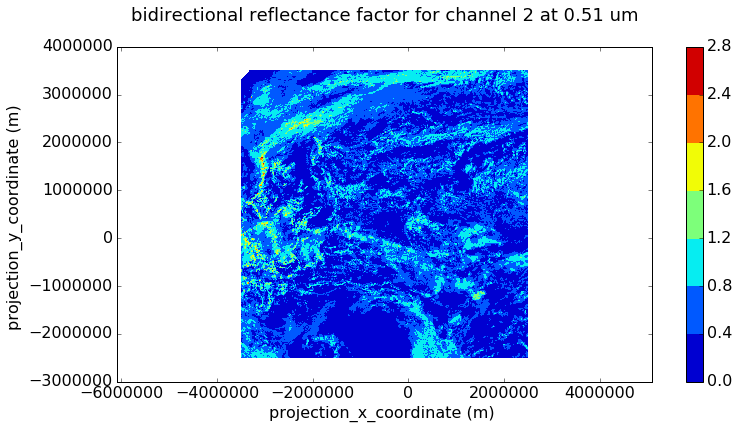

In [11]:
# Set figure size
plt.figure(figsize=(12,6))

# Plot data subset with equal axes and colorbar
plt.contourf(x_subset, y_subset, ch02_subset)
plt.axis('equal')
cbar = plt.colorbar()

# Add figure title and labels
# We can make use of the defined variable attributes to do this
plt.title(ch02.long_name+'\n', fontsize=18)
plt.xlabel(x.long_name+' ('+x.units+') ', fontsize=16)
plt.ylabel(y.long_name+' ('+y.units+') ', fontsize=16)

# Adjust tick mark size
cbar.ax.tick_params(labelsize=16) 
plt.tick_params(labelsize=16)


## Save subset to new netCDF file

If only using a small subset of a much larger dataset, it can sometimes be useful to save the subset to a new file for smoother use with other tools. 

**Note:** NCO (NetCDF Operators) tools provide a much simpler way of copying netCDF subsets to new files. For more  information using NCO: [NCO tutorial](https://nbviewer.jupyter.org/github/kdruken/Notebooks/blob/master/NCO.ipynb)

#### Create and open new file

In [12]:
new_nc = Dataset('new_file.nc', 'w')

#### Create new dimensions

In [13]:
xdim = new_nc.createDimension('x', len(x_subset))
ydim = new_nc.createDimension('y', len(y_subset))
tdim = new_nc.createDimension('t', f.dimensions['time'].size)

#### Create new variables

In [14]:
x_new = new_nc.createVariable('x', x.datatype, ('x',))
y_new = new_nc.createVariable('y', y.datatype, ('y',))
t_new = new_nc.createVariable('t', t.datatype, ('t',))

ch02_new = new_nc.createVariable('channel_0002_brf', 'f8', ('t','y','x',))
geo_new = new_nc.createVariable('geostationary', f['geostationary'].datatype, ())

#### Write data from subset

In [15]:
x_new[:] = x_subset
y_new[:] = y_subset
t_new[:] = t[:]
ch02_new[:,:,:] = ch02_subset

#### Copy metadata and variable attributes into new file

In [16]:
# Global attributes
for item, value in f.__dict__.items():
    new_nc.__setattr__(item, value)

In [17]:
# Variable attributes
variables = [(t, t_new), (y, y_new), (x, x_new), (ch02, ch02_new), (f['geostationary'], geo_new)]

for vold, vnew in variables:
    for item, value in vold.__dict__.items():
        # Special attributes that begin with '_' (e.g., _FillValue, _ChunkSize, etc.) 
        # need to be defined when first creating the variable, 
        # in this simple example these attributes are ignored
        if not item.startswith('_'):
            vnew.__setattr__(item, value)
        

#### Close file

In [18]:
new_nc.close()